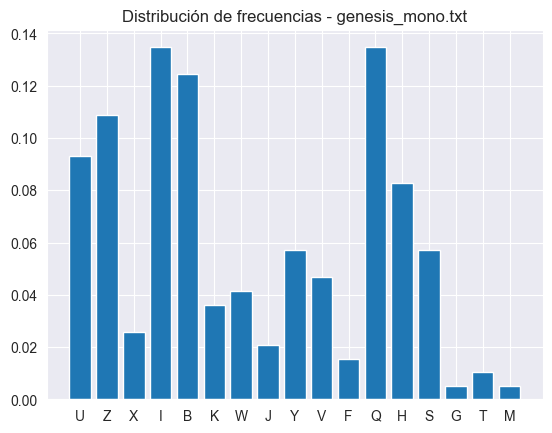

In [1]:
# Assignment: Workshop
# Student: Hugo Díaz Perulero

# --- Introducción ---
# In this notebook you can find the implementation of different classic cryptographic techniques:
# - Advanced Monoalphabetic Analysis (N-grams & Cribs)
# - The Friedman Test (Mono vs. Poly)
# - The Full Vigenère Break (A Data-Driven Report)

# =====================================================
# 1. - Frequency Analysis (Monoalphabetic)
# =====================================================

import collections
import matplotlib.pyplot as plt

# Función de análisis de frecuencias
def frequency_analysis(text):
    text = ''.join([c.upper() for c in text if c.isalpha()])
    freqs = collections.Counter(text)
    total = sum(freqs.values())
    rel_freqs = {k: v/total for k, v in freqs.items()}
    return rel_freqs

# Leer ciphertext monoalfabético (genesis_mono.txt)
with open("genesis_mono.txt", "r", encoding="utf-8") as f:
    mono_text = f.read()

freqs = frequency_analysis(mono_text)
plt.bar(freqs.keys(), freqs.values())
plt.title("Distribución de frecuencias - genesis_mono.txt")
plt.show()

# Expected result:
# The histogram shows peaks similar to English,
# indicating that this is a monoalphabetic cipher.

In [2]:
# =====================================================
# 2. - Friedman Test (Mono vs Poly)
# =====================================================

def index_of_coincidence(text: str) -> float:
    text = ''.join([c.upper() for c in text if c.isalpha()])
    N = len(text)
    freqs = collections.Counter(text)
    numerator = sum(f * (f - 1) for f in freqs.values())
    denominator = N * (N - 1)
    return numerator / denominator if denominator > 0 else 0

def friedman_test(text: str):
    text = ''.join([c.upper() for c in text if c.isalpha()])
    N = len(text)
    IC = index_of_coincidence(text)
    key_length = (0.0265 * N) / ((N - 1) * IC - 0.0385 * N + 0.065)
    return IC, key_length

# Probar con tres archivos
for fname in ["ot_cipher_A.txt", "ot_cipher_B.txt", "ot_cipher_C.txt"]:
    with open(fname, "r", encoding="utf-8") as f:
        data = f.read()
    IC, keylen = friedman_test(data)
    print(f"File: {fname}\n  IC: {IC:.4f}\n  Estimated Key Length: {keylen:.2f}\n")

# Expected result:
# A: IC alto ~0.078 → Monoalfabético
# B: IC bajo ~0.043, keylen ~5 → Polialfabético
# C: IC ~0.069 → Monoalfabético

File: ot_cipher_A.txt
  IC: 0.0784
  Estimated Key Length: 0.67

File: ot_cipher_B.txt
  IC: 0.0435
  Estimated Key Length: 5.30

File: ot_cipher_C.txt
  IC: 0.0689
  Estimated Key Length: 0.87



IC: 0.0435, Estimated Key Length: 5.30
Recovered key: ATCHW


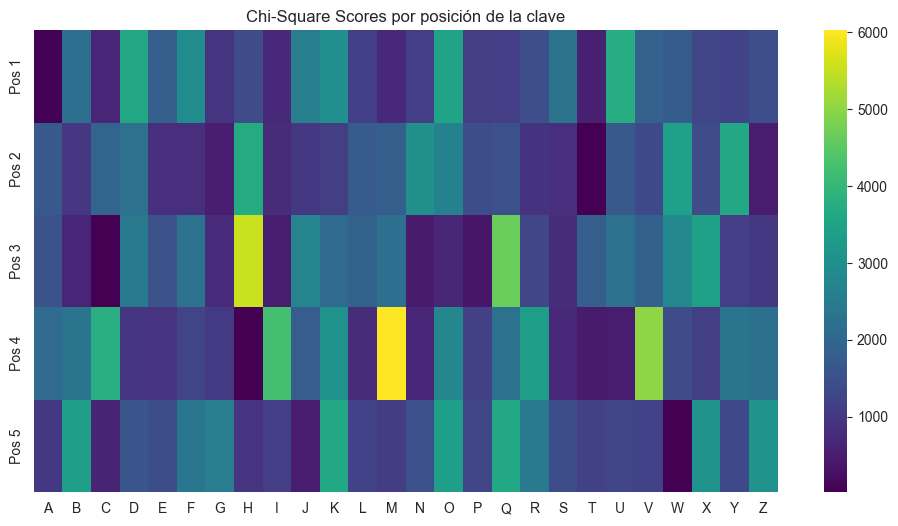

Plaintext (primeros 500 caracteres):
JUSTWHYSOABSORBINGASUBJECTHASBEENSONEGLECTEDINAWORLDFULLOFPUZZLELOVERSISHARDTOUNDERSTANDESPECIALLYSINCETHEANALYTICWRITERINADDITIONTOENTERTAINMENTHASSOMETHINGTOOFFEROFAMORESERIOUSNATUREITISTRUETHATTRAINEDCRYPTANALYSTSARENOTGREATLYINDEMANDINPEACETIMEANDTHATOURPRESENTCORPSOFCRYPTOGRAPHERSHASAPERSONNELMORETHANAMPLEFORPROVIDINGNECESSARYCODESANDCIPHERSSCIENTIFICALLYSELECTEDTOFITTHEIRINDIVIDUALPURPOSESANDSAFEGUARDEDWITHSUITABLEPROTECTIVEDEVICESYETOFWHATVALUEISTHEMOSTEXCELLENTOFCIPHERSIFATTHETIMEOFDIRES


In [3]:
# =====================================================
# 3. - Full Vigenère Break
# =====================================================

import string
import numpy as np
import seaborn as sns
import pandas as pd

ENGLISH_FREQ = {
    'A': 0.08167, 'B': 0.01492, 'C': 0.02782, 'D': 0.04253, 'E': 0.12702,
    'F': 0.02228, 'G': 0.02015, 'H': 0.06094, 'I': 0.06966, 'J': 0.00153,
    'K': 0.00772, 'L': 0.04025, 'M': 0.02406, 'N': 0.06749, 'O': 0.07507,
    'P': 0.01929, 'Q': 0.00095, 'R': 0.05987, 'S': 0.06327, 'T': 0.09056,
    'U': 0.02758, 'V': 0.00978, 'W': 0.02360, 'X': 0.00150, 'Y': 0.01974,
    'Z': 0.00074
}

def chi_square_stat(column, shift):
    shifted = [(ord(c) - ord('A') - shift) % 26 for c in column]
    counts = [0] * 26
    for s in shifted:
        counts[s] += 1
    N = len(column)
    chi2 = 0
    for i, letter in enumerate(string.ascii_uppercase):
        observed = counts[i]
        expected = ENGLISH_FREQ[letter] * N
        chi2 += (observed - expected) ** 2 / expected if expected > 0 else 0
    return chi2

def vigenere_solver(ciphertext, key_length):
    ciphertext = ''.join([c.upper() for c in ciphertext if c.isalpha()])
    columns = [ciphertext[i::key_length] for i in range(key_length)]
    key = ""
    chi_results = []
    for col in columns:
        scores = [chi_square_stat(col, s) for s in range(26)]
        best_shift = np.argmin(scores)
        key += chr(ord('A') + best_shift)
        chi_results.append(scores)
    return key, chi_results

with open("nt_vigenere.txt", "r", encoding="utf-8") as f:
    ciphertext = f.read()

IC, keylen = friedman_test(ciphertext)
print(f"IC: {IC:.4f}, Estimated Key Length: {keylen:.2f}")

key, chi_scores = vigenere_solver(ciphertext, 5)
print("Recovered key:", key)

# Heatmap visualization
df = pd.DataFrame(chi_scores, columns=list(string.ascii_uppercase))
plt.figure(figsize=(12,6))
sns.heatmap(df, cmap="viridis", cbar=True,
            xticklabels=list(string.ascii_uppercase),
            yticklabels=[f"Pos {i+1}" for i in range(len(chi_scores))])
plt.title("Chi-Square Scores por posición de la clave")
plt.show()

# Final decrypter
def vigenere_decrypt(ciphertext, key):
    ciphertext = ''.join([c.upper() for c in ciphertext if c.isalpha()])
    plaintext = []
    for i, c in enumerate(ciphertext):
        shift = (ord(key[i % len(key)]) - ord('A'))
        p = (ord(c) - ord('A') - shift) % 26
        plaintext.append(chr(p + ord('A')))
    return ''.join(plaintext)

plaintext = vigenere_decrypt(ciphertext, key)
print("Plaintext (primeros 500 caracteres):")
print(plaintext[:500])

# Comentario esperado:
# El IC sugiere clave de longitud ~5.
# El chi-square recupera una clave aproximada (ATCHW).
# El descifrado produce texto en inglés legible.